In [1]:
import astropy
from astropy.timeseries import LombScargle
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astroplan.plots import plot_airmass
from astroplan import Observer, FixedTarget, AirmassConstraint, AtNightConstraint
from astroplan import is_observable, months_observable
import astropy.units as u
from tqdm import tqdm

np.random.seed(42)


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [2]:
observer = Observer.at_site('lapalma')
coordinates = SkyCoord('00h00m00.0s', '+45d00m00.0s', frame='icrs')
target = FixedTarget(name='target star', coord=coordinates)

In [3]:
survey_start = Time('2000-03-01 12:00:00')
survey_dates = []
survey_length = 365 * 10 # leap years? never heard of her

Cut down to just the nights in the year when we have a shot at observing -- there has got to be a more efficient way of doing this!:

In [4]:
constraints = [AirmassConstraint(1.5), AtNightConstraint.twilight_nautical()]
good_months = list(months_observable(constraints, observer, [target])[0])  # preliminary check to save some time
good_months

[1, 2, 5, 6, 7, 8, 9, 10, 11, 12]

In [5]:
d = survey_start.copy() # start time of the day to be tested
for n in tqdm(range(survey_length)):
    if np.isin(d.ymdhms['month'], good_months):
        if is_observable(constraints, observer, target, 
                         time_range=[d, 
                                     d + TimeDelta(1.*u.day)]):
            survey_dates.append(d.copy())
    d += TimeDelta(1.*u.day)

100%|██████████| 3650/3650 [04:34<00:00, 13.30it/s]


In [6]:
len(survey_dates)

2556

### Once a night every possible night strategies:

In [7]:
t_zeniths = np.zeros(len(survey_dates)) + np.nan
t_zeniths_type = []
t_randomized = np.zeros(len(survey_dates)) + np.nan

dark_horizon = -12. * u.deg # horizon for sunset/sunrise crossing - nautical twilight

for i,t in tqdm(enumerate(survey_dates)):
    t_rise = observer.target_rise_time(t, target, which='nearest', horizon=30.*u.deg)
    t_set = observer.target_set_time(t_rise, target, which='next', horizon=30.*u.deg)
    t_zenith = t_rise + (t_set - t_rise)/2.
    if observer.is_night(t_zenith, horizon=dark_horizon):
        t_zeniths[i] = np.copy(t_zenith.jd)
        t_zeniths_type.append('zenith')
    elif observer.is_night(t_rise, horizon=dark_horizon):
        t_zeniths[i] = np.copy(observer.sun_rise_time(t_rise, horizon=dark_horizon, which='next').jd)
        t_zeniths_type.append('end of night')
    else:
        t_zeniths[i] = np.copy(observer.sun_set_time(t_rise, horizon=dark_horizon, which='next').jd) 
        t_zeniths_type.append('start of night')

    # the following is slow but idk how to be more clever in astroplan:
    for j in range(512):
        t_random = t_zenith + (np.random.random() * 10. - 5.) * TimeDelta(1.*u.hour) # perturb by 5 hours in either direction
        if is_observable(constraints, observer, target, times=t_random):
            t_randomized[i] = np.copy(t_random.jd)
            break

2556it [25:14,  1.69it/s]


In [8]:
t_zeniths_type = np.array(t_zeniths_type)

In [9]:
t_randomized_keep = np.copy(t_randomized)
t_randomized_keep

array([2451690.7137486 , 2451691.71888679, 2451692.70571924, ...,
       2455231.32561507, 2455232.33144611, 2455233.32532796])

Sanity checks:

In [10]:
np.sum(np.isfinite(t_randomized))
# there may be some NaNs left at the ends of observing seasons. we can patch these later.

2554

In [11]:
np.sum(np.isfinite(t_zeniths))

2556

start of night


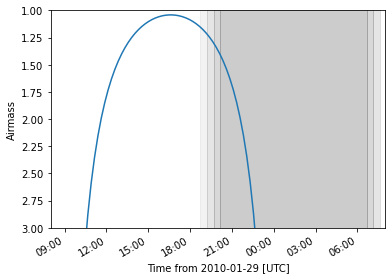

In [12]:
ind = -8
plot_airmass(target, observer, survey_dates[ind]+TimeDelta(8.*u.hour), 
             brightness_shading=True)
print(t_zeniths_type[ind])

In [13]:
Time(t_randomized[ind], format='jd').datetime

datetime.datetime(2010, 1, 29, 20, 13, 59, 313224)

In [14]:
Time(t_zeniths[ind], format='jd').datetime

datetime.datetime(2010, 1, 29, 19, 41, 23, 445539)

In [15]:
t_rise = observer.target_rise_time(survey_dates[ind], target, which='nearest', horizon=30.*u.deg)
t_rise.datetime
observer.is_night(t_rise, horizon=-12.*u.deg)

False

In [16]:
sunset = observer.sun_set_time(t_rise, horizon=-12*u.deg, which='next')
sunset.datetime

datetime.datetime(2010, 1, 29, 19, 41, 23, 445539)

In [17]:
observer.altaz(Time(sunset, format='jd'), target).secz.value

1.301293413105458

In [18]:
airmasses_zenith = np.zeros_like(t_zeniths)
for i,tz in enumerate(t_zeniths):
    try:
        airmasses_zenith[i] = observer.altaz(Time(tz, format='jd'), target).secz.value
    except ValueError:
        continue

In [19]:
airmasses_random = np.zeros_like(t_randomized)
for i,tr in enumerate(t_randomized):
    try:
        airmasses_random[i] = observer.altaz(Time(tr, format='jd'), target).secz.value
    except ValueError:
        continue

In [20]:
airmasses_zenith[ind]

1.301293413105458

In [21]:
np.sum(np.isfinite(t_randomized))

2554

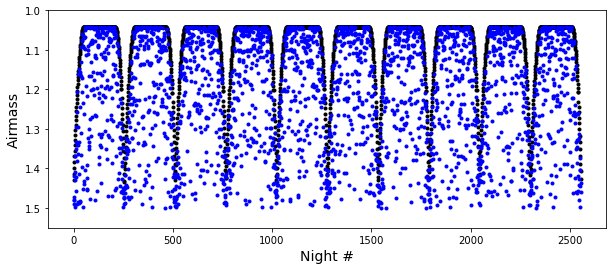

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax.plot(airmasses_zenith, 'k.')
ax.plot(airmasses_random, 'b.')
ax.set_ylim([1.55,1.0])
ax.set_ylabel('Airmass', fontsize=14)
ax.set_xlabel('Night #', fontsize=14);

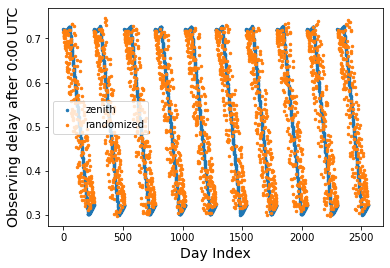

In [23]:
day_inds = np.arange(len(t_zeniths))
plt.scatter(day_inds, t_zeniths % 1.0, label='zenith', s=6)
plt.scatter(day_inds, t_randomized % 1.0, label='randomized', s=6)
plt.xlabel('Day Index', fontsize=14)
plt.ylabel('Observing delay after 0:00 UTC', fontsize=14)
plt.legend();
#plt.plot(day_inds, sunrises, label='sunrise')
#plt.plot(day_inds, sunsets, label='sunset')

### Strict zenith-only:

In [ ]:
t_zeniths_strict = t_zeniths[t_zeniths_type == 'zenith']

### Extreme randomized:

We're not going to worry too much about the practicality of this schedule, other than the following conditions: 
- observing conditions on darkness and airmass must be satisfied
- total number of observations are the same as in other survey configurations, when averaged over 10 years

Some things that we're not correcting, despite slight wrongness:
- end-of-night observations can continue slightly into daytime
- start times could in principle be "overlapping" (exposure #1 does not have time to complete before the next one must begin)
- total number of observations *per season* is not necessarily the same as in other survey configurations

In [26]:
N = len(t_obs_zenith) # number of observations to reach
start_jd = observer.sun_set_time(Time(t_obs_zenith[0], format='jd'), 
                                 horizon=dark_horizon, which='previous').jd
end_jd = observer.sun_rise_time(Time(t_obs_zenith[-1], format='jd'), 
                                horizon=dark_horizon, which='next').jd

In [27]:
t_super_random = []
while len(t_super_random) < N:
    tt_jd = np.random.uniform(start_jd, end_jd)
    tt = Time(tt_jd, format='jd')
    if is_observable(constraints, observer, target, times=tt):
        t_super_random.append(tt_jd)
        if len(t_super_random) % 500 == 0:
            print("{0} acceptable times reached at {1}".format(len(t_super_random), 
                                                               Time.now().datetime64))
t_super_random = np.array(t_super_random)
t_super_random = np.sort(t_super_random)

500 acceptable times reached at 2020-05-18T19:40:29.012972000
1000 acceptable times reached at 2020-05-18T19:42:51.767542000
1500 acceptable times reached at 2020-05-18T19:45:19.908611000
2000 acceptable times reached at 2020-05-18T19:47:40.793287000
2500 acceptable times reached at 2020-05-18T19:50:08.889613000


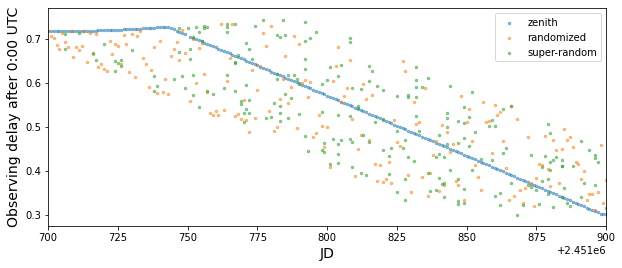

In [32]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
day_inds = np.arange(len(t_zeniths))
ax.scatter(np.floor(t_zeniths), t_zeniths % 1.0, label='zenith', s=6, alpha=0.5)
ax.scatter(np.floor(t_randomized), t_randomized % 1.0, label='randomized', s=6, alpha=0.5)
ax.scatter(np.floor(t_super_random), t_super_random % 1.0, label='super-random', s=6, alpha=0.5)
ax.set_xlabel('JD', fontsize=14)
ax.set_ylabel('Observing delay after 0:00 UTC', fontsize=14)
ax.legend()
ax.set_xlim([np.floor(t_zeniths[10]), np.floor(t_zeniths[10]) + 200]);

### Save everything:

In [9]:
def save_times(times, filename, ref_time=survey_start.jd):
    ts = times - ref_time
    with open(filename, 'w') as f:
        f.write('t (days)\n')
        for t in ts:
            f.write('{0:.8f}\n'.format(t))

In [30]:
save_times(t_zeniths, 't_zeniths.txt')
save_times(t_randomized, 't_randomized.txt')
save_times(t_zeniths_strict, 't_zeniths_strict.txt')
save_times(t_super_random, 't_super_random.txt')